In [1]:
# Step 1: Import required libraries
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import TomekLinks
from sklearn.preprocessing import StandardScaler
from collections import Counter
import pandas as pd

# Step 2: Load your dataset
df = pd.read_csv("all_three.csv")  # replace with your actual path

# Step 3: Separate features and label
X = df.drop(columns=["label", "Unnamed: 0"])  # drop label and any index column
y = df["label"]

# Step 4: Normalize features (important for distance-based sampling)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 5: Apply ADASYN for multi-class oversampling
adasyn = ADASYN(sampling_strategy='not majority', random_state=42, n_neighbors=5)
X_ada, y_ada = adasyn.fit_resample(X_scaled, y)

# Step 6: Apply Tomek Links to remove borderline examples
tl = TomekLinks()
X_final, y_final = tl.fit_resample(X_ada, y_ada)

# Step 7: Compare class distributions
print("Original class distribution:", Counter(y))
print("After ADASYN:", Counter(y_ada))
print("After Tomek Links:", Counter(y_final))


Original class distribution: Counter({0: 335847, 2: 55390, 3: 34134, 1: 2254})
After ADASYN: Counter({3: 336054, 1: 336019, 0: 335847, 2: 335844})
After Tomek Links: Counter({1: 336019, 2: 335844, 3: 334279, 0: 334072})


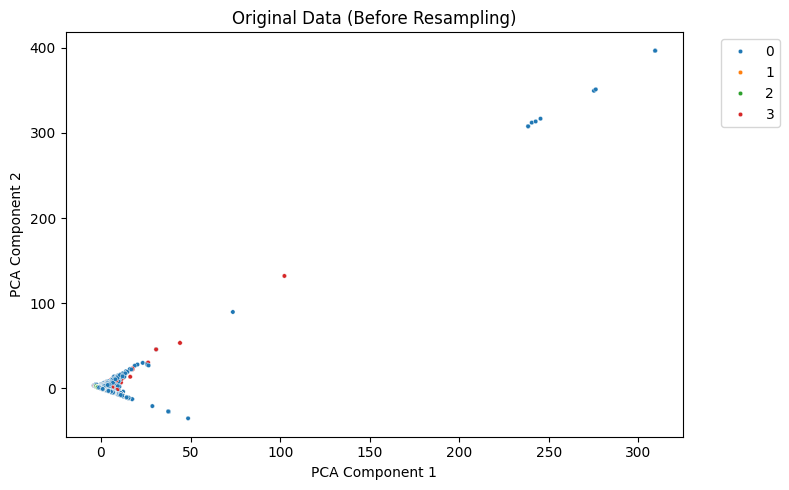

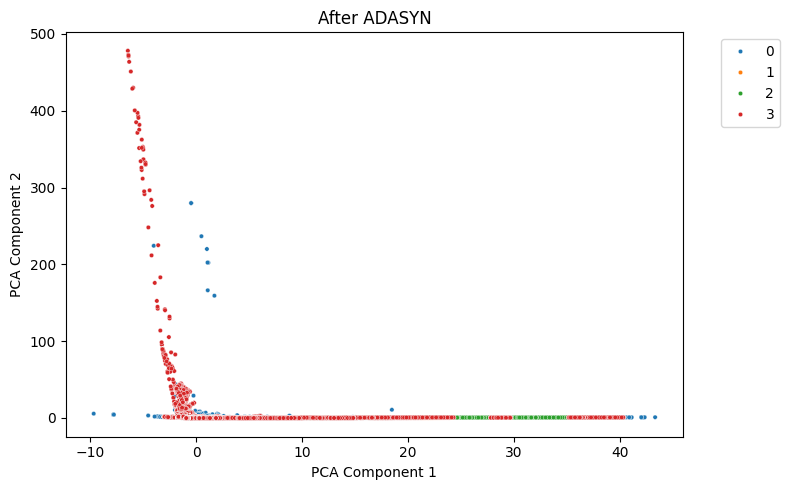

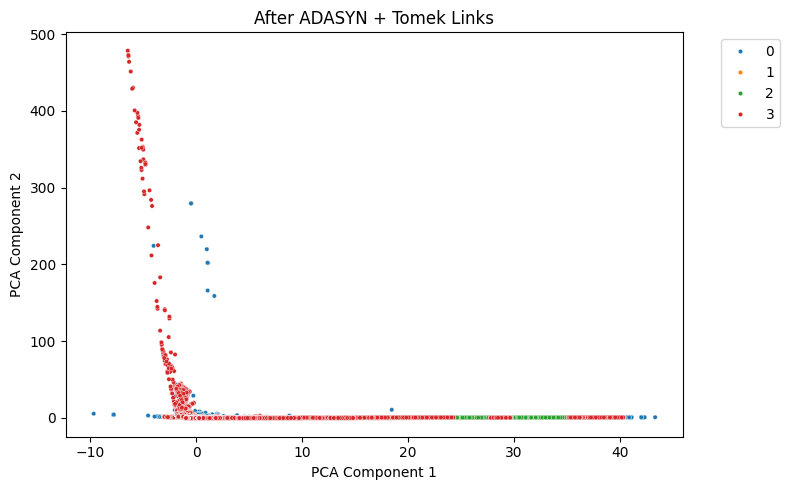

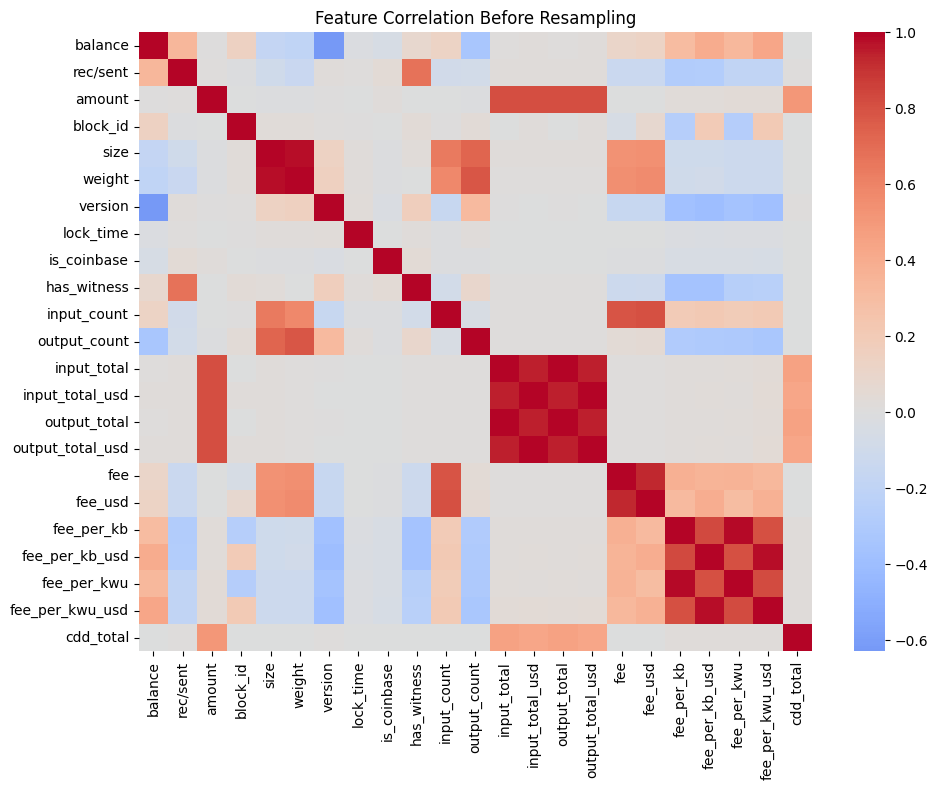

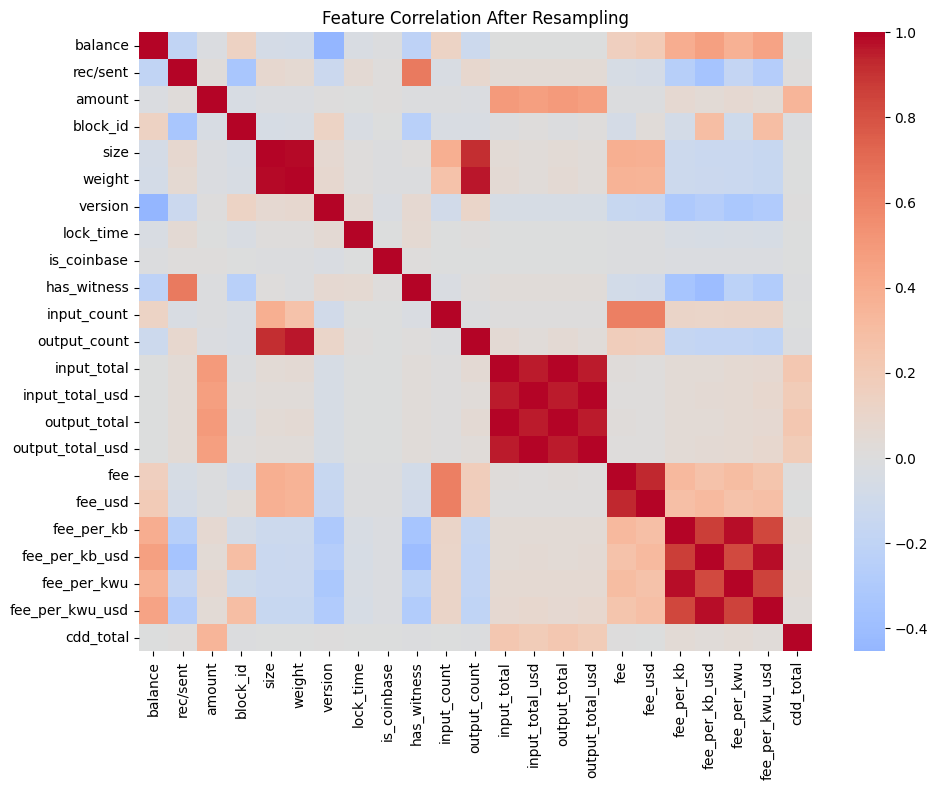

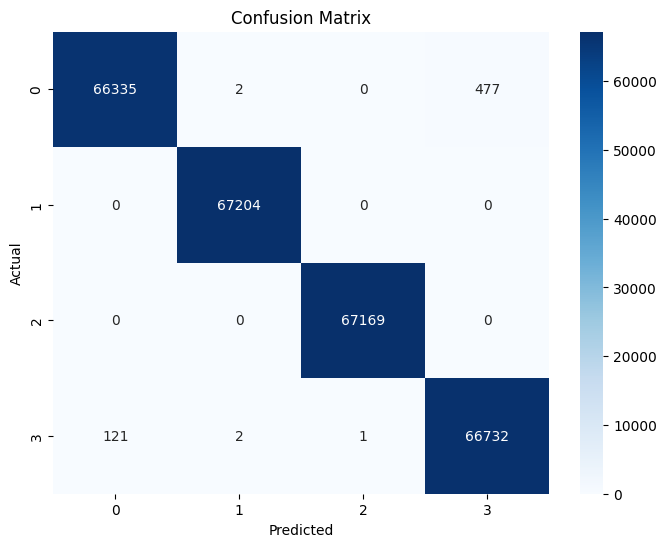

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00     66814
           1       1.00      1.00      1.00     67204
           2       1.00      1.00      1.00     67169
           3       0.99      1.00      1.00     66856

    accuracy                           1.00    268043
   macro avg       1.00      1.00      1.00    268043
weighted avg       1.00      1.00      1.00    268043



(Counter({0: 335847, 2: 55390, 3: 34134, 1: 2254}),
 Counter({3: 336054, 1: 336019, 0: 335847, 2: 335844}),
 Counter({1: 336019, 2: 335844, 3: 334279, 0: 334072}))

In [3]:
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import TomekLinks
from sklearn.preprocessing import StandardScaler
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Step 5: PCA Visualization Function
def plot_pca(X_data, y_data, title):
    pca = PCA(n_components=2)
    components = pca.fit_transform(X_data)
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=components[:, 0], y=components[:, 1], hue=y_data, palette='tab10', legend='full', s=10)
    plt.title(title)
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Step 6: Correlation Heatmap Function
def plot_corr(X_data, title):
    df_corr = pd.DataFrame(X_data, columns=X.columns).corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(df_corr, cmap='coolwarm', center=0, annot=False, fmt=".2f")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# PCA plots
plot_pca(X_scaled, y, "Original Data (Before Resampling)")
plot_pca(X_ada, y_ada, "After ADASYN")
plot_pca(X_final, y_final, "After ADASYN + Tomek Links")

# Correlation heatmaps
plot_corr(X_scaled, "Feature Correlation Before Resampling")
plot_corr(X_final, "Feature Correlation After Resampling")

# Step 7: Train-test split and model evaluation
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.2, random_state=42, stratify=y_final)
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_final), yticklabels=np.unique(y_final))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification report
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

# Print class distributions
original_dist = Counter(y)
after_adasyn_dist = Counter(y_ada)
final_dist = Counter(y_final)
original_dist, after_adasyn_dist, final_dist


In [4]:
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import TomekLinks

# Step 1: Prepare features and labels
X = df.drop(columns=["label", "Unnamed: 0"])
y = df["label"]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 2: Function to apply ADASYN + TomekLinks and return stats
def apply_adasyn_tomek(split_ratio):
    train_size = split_ratio / 100
    X_train, _, y_train, _ = train_test_split(X_scaled, y, train_size=train_size, random_state=42, stratify=y)

    # ADASYN oversampling
    adasyn = ADASYN(sampling_strategy='not majority', random_state=42)
    X_ada, y_ada = adasyn.fit_resample(X_train, y_train)

    # Tomek Links undersampling
    tl = TomekLinks()
    X_final, y_final = tl.fit_resample(X_ada, y_ada)

    # Count per class
    counter = Counter(y_final)
    sample_counts = [counter.get(cls, 0) for cls in sorted(y.unique())]

    # Determine oversampling condition
    majority_class = max(counter, key=counter.get)
    condition = ", ".join([f"Class {cls} → match Class {majority_class}"
                           for cls in counter if cls != majority_class and counter[cls] == counter[majority_class]])

    return sample_counts, condition

# Step 3: Loop over split ratios and gather data
ratios = [60, 70, 80]
results = {"Technique_Name": "ADASYN+TomekLinks", "Splitting Ratio": ["60:40:00", "70:30:00", "80:20:00"]}
samples = {f"Sample {cls}": [] for cls in sorted(y.unique())}
conditions = []

for r in ratios:
    sample_counts, condition = apply_adasyn_tomek(r)
    for idx, cls in enumerate(sorted(y.unique())):
        samples[f"Sample {cls}"].append(sample_counts[idx])
    conditions.append(condition)

# Add sample counts and condition to results
for key in samples:
    results[key] = samples[key]
results["Condition of Oversampling"] = conditions

# Step 4: Format as final table
summary_df = pd.DataFrame(results)

# Show table
summary_df


,Technique_Name,Splitting Ratio,Sample 0,Sample 1,Sample 2,Sample 3,Condition of Oversampling
0,ADASYN+TomekLinks,60:40:00,200610,201397,201489,200858,
1,ADASYN+TomekLinks,70:30:00,233992,235098,235094,234674,
2,ADASYN+TomekLinks,80:20:00,267350,268714,268681,268147,
